# Neural Network Implementation
### Christopher W. Hong

## Neural Network Class

In [198]:
import numpy as np
import matplotlib.pyplot as plt

class NeuralNetwork():
    """Multi-layer neural network classifier."""
    
    def __init__(self, n_input_nodes, n_output_nodes, n_hidden_nodes=16, eta = 1e-2, n_layers=3, seed=0):
        """Define the model structure and initialize weights."""
        # Set the layer sizes
        self.random = np.random.RandomState(seed)
        self.n_input_nodes = n_input_nodes
        self.n_hidden_nodes = n_hidden_nodes
        self.n_output_nodes = n_output_nodes
        self.n_layers = n_layers
        self.eta = eta
        
        # Initialize parameters
        self.parameters = {}
        self.parameters['W1'] = np.random.randn(self.n_input_nodes, self.n_hidden_nodes) * 0.01
        self.parameters['b1'] = np.zeros((1, self.n_hidden_nodes))
        self.parameters['W2'] = np.random.randn(self.n_hidden_nodes, self.n_hidden_nodes) * 0.01
        self.parameters['b2'] = np.zeros((1, self.n_hidden_nodes))
        self.parameters['W3'] = np.random.randn(self.n_hidden_nodes, self.n_output_nodes) * 0.01
        self.parameters['b3'] = np.zeros((1, self.n_output_nodes))
        
    def _sigmoid(self, z):
        """Implement the sigmoid function."""
        return 1. / (1. + np.exp(-z))
    
    def _grad_sigmoid(self, z):
        """Compute the gradients of sigmoid."""
        return self._sigmoid(z) * (1 - self._sigmoid(z))
    
    def _softmax(self, z):
        """Implement the softmax function."""
        exps = np.exp(z - np.max(z, axis=1, keepdims=True))
        
        return exps / np.sum(exps, axis=1, keepdims=True) # Normalize the probabilities
    
    def forward_propagation(self, X):
        """Implement forward pass."""
        caches = {}
        
        # Input to the first hidden layers
        z_h_1 = X @ self.parameters['W1'] + self.parameters['b1']
        # Output of the first hidden layers
        a_h_1 = self._sigmoid(z_h_1)
        # Store the intermediate results
        caches['Z1'] = z_h_1
        caches['A1'] = a_h_1

        # Input to the second hidden layers
        z_h_2 = a_h_1 @ self.parameters['W2'] + self.parameters['b2']
        # Output of the second hidden layers
        a_h_2 = self._sigmoid(z_h_2)
        # Store the intermediate results
        caches['Z2'] = z_h_2
        caches['A2'] = a_h_2
            
        # Input to the output layers
        z_h_o = a_h_2 @ self.parameters['W3'] + self.parameters['b3']
        # Output of the final layers
        y_hat = self._softmax(z_h_o)
        # Store the final results
        caches['Z3'] = z_h_o
        caches['y_hat'] = y_hat
        
        return y_hat, caches
    
    def backward_propagation(self, X, y, y_hat, caches):
        """Implement backward pass."""
        grads = {}
        
        # Calculate the loss
        grad_y_hat = y_hat - y
        
        # Calculate the gradients of the output parameters
        grads['dW3'] = caches['A2'].T @ grad_y_hat
        grads['db3'] = np.sum(grad_y_hat, axis=0, keepdims=True)
        
        # Backward propagate the gradient to the second layer
        grad_2 = grad_y_hat @ self.parameters['W3'].T * self._grad_sigmoid(caches['Z2'])
        
        # Calculate the gradients of the parameters of the second layer
        grads['dW2'] = caches['A1'].T @ grad_2
        grads['db2'] = np.sum(grad_2, axis=0, keepdims=True)
        
        # Backward propagate the gradient to the first layer
        grad_1 = grad_2 @ self.parameters['W2'].T * self._grad_sigmoid(caches['Z1'])
        
        # Calculate the gradients of the parameters of the first layer
        grads['dW1'] = X.T @ grad_1
        grads['db1'] = np.sum(grad_1, axis=0, keepdims=True)
              
        return grads
    
    def update_parameters(self, grads):
        """Update parameters using gradient descent."""
        for layer in range(1, self.n_layers+1):
            self.parameters['W'+str(layer)] -= self.eta * grads['dW'+str(layer)]
            self.parameters['b'+str(layer)] -= self.eta * grads['db'+str(layer)]
            
    def _sgd(self, X, y):
        """Implement the SGD."""
        # Yield examples one by one
        for i in range(0, X.shape[0]):
            yield X[i].reshape(1,-1), y[i].reshape(1,-1)
            
    def fit(self, X, y, epochs=2000, print_loss=True):
        """Train the network from training data."""
        history = {}
        history['loss'] = []
        history['acc'] = []
        
        for i in range(epochs):
            losses = np.zeros(X.shape[0])
            accs = np.zeros(X.shape[0])
            ind = 0
            for X_sgd, y_sgd in self._sgd(X, y):
                y_hat, caches = self.forward_propagation(X_sgd)
                losses[ind] = self.compute_loss(y_sgd, y_hat)
                grads = self.backward_propagation(X_sgd, y_sgd, y_hat, caches)
                self.update_parameters(grads)
                accs[ind] = self.evaluate(X_sgd, y_sgd)
                ind += 1
            history['loss'].append(np.sum(losses))
            history['acc'].append(np.mean(accs))
            if print_loss and i % 100 == 0:
                print('epochs: {}\tloss: {:.2f}\tacc: {:.2f}%'.format(\
                    i, np.average(history['loss']), np.mean(history['acc'])))
        
        return history
            
    def predict(self, X):
        """Using the learned parameters to predict the label of each sample."""
        y_hat, caches = self.forward_propagation(X)
        
        return np.argmax(y_hat, axis=1)
    
    def evaluate(self, X, y):
        """Evaluate the accuracy rate of the network."""
        y_hat = self.predict(X)
        y = y.argmax(axis=1)
        acc = (y_hat==y).mean() * 100
        
        return acc    
        
    def compute_loss(self, y, y_hat):
        """Implement the categorical crossentropy loss function."""
        # Calcuate the loss
        y = y.argmax(axis=1) # y is one-hot encoding vectors
        log_probs = -np.log(y_hat[range(y.shape[0]),y] + 1e-6)
        loss= np.sum(log_probs)
        
        return loss
    
    def plot_performance(self, history):
        """Plot the training loss and accuracy."""
        loss = history['loss']
        epochs = range(1, len(loss)+1)

        plt.plot(epochs, loss, 'b', label='Training loss')
        plt.title('Training loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.show();

        plt.clf()

        acc = history['acc']

        plt.plot(epochs, acc, 'b', label='Training acc')
        plt.title('Training accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Acc')
        plt.legend()

        plt.show();

In [199]:
def plot_model_performance(history):
    loss = history.history['loss']
    epochs = range(1, len(loss)+1)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.title('Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show();
    
    plt.clf()
    acc = history.history['accuracy']
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.title('Training accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend()

    plt.show();

In [168]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Iris dataset

In [201]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

In [202]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train ,y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

In [203]:
y_train = np.asarray(to_categorical(y_train)).astype('float32')
y_test = np.asarray(to_categorical(y_test)).astype('float32')

In [204]:
nn = NeuralNetwork(X_train.shape[1], 3, 32)
history = nn.fit(X_train, y_train, 5001)

epochs: 0	loss: 117.72	acc: 49.52%
epochs: 100	loss: 117.50	acc: 46.90%
epochs: 200	loss: 117.25	acc: 46.73%
epochs: 300	loss: 110.61	acc: 51.96%
epochs: 400	loss: 91.31	acc: 62.42%
epochs: 500	loss: 76.81	acc: 69.05%
epochs: 600	loss: 66.08	acc: 73.53%
epochs: 700	loss: 58.05	acc: 76.69%
epochs: 800	loss: 51.89	acc: 79.23%
epochs: 900	loss: 47.02	acc: 81.22%
epochs: 1000	loss: 43.08	acc: 82.88%
epochs: 1100	loss: 39.84	acc: 84.27%
epochs: 1200	loss: 37.11	acc: 85.42%
epochs: 1300	loss: 34.80	acc: 86.39%
epochs: 1400	loss: 32.80	acc: 87.23%
epochs: 1500	loss: 31.07	acc: 87.95%
epochs: 1600	loss: 29.54	acc: 88.58%
epochs: 1700	loss: 28.20	acc: 89.14%
epochs: 1800	loss: 26.99	acc: 89.64%
epochs: 1900	loss: 25.92	acc: 90.09%
epochs: 2000	loss: 24.95	acc: 90.49%
epochs: 2100	loss: 24.06	acc: 90.85%
epochs: 2200	loss: 23.26	acc: 91.18%
epochs: 2300	loss: 22.53	acc: 91.48%
epochs: 2400	loss: 21.86	acc: 91.75%
epochs: 2500	loss: 21.24	acc: 92.01%
epochs: 2600	loss: 20.66	acc: 92.24%
epochs: 2

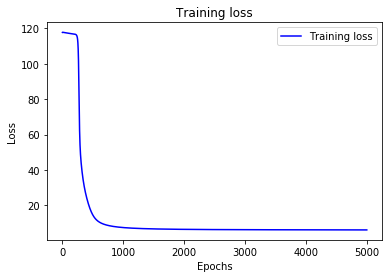

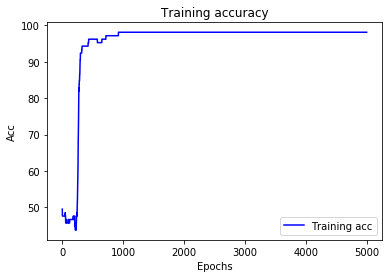

In [205]:
nn.plot_performance(history)

In [207]:
print('Test acc:', nn.evaluate(X_test, y_test))

Test acc: 100.0


### Keras model

In [208]:
import keras
import pandas as pd
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical

In [214]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(32, activation='sigmoid', input_shape=(4,)))
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dense(3, activation='softmax'))

In [215]:
opt = keras.optimizers.SGD(learning_rate=1e-2)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [216]:
history = model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=0)

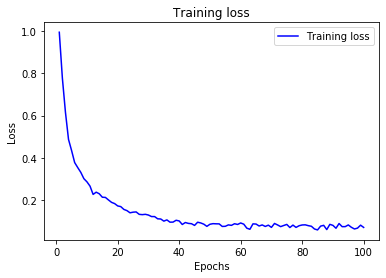

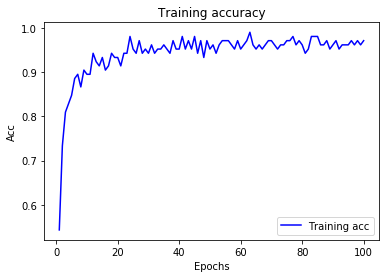

In [217]:
plot_model_performance(history)

In [218]:
model.evaluate(X_test, y_test)

45/45 [==============================] - 0s 2ms/step


[0.03910314137529996, 0.9777777791023254]

## Wine dataset

In [219]:
wine = datasets.load_wine()

In [220]:
X = wine.data
y = wine.target

In [221]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train ,y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)
y_train = np.asarray(to_categorical(y_train)).astype('float32')
y_test = np.asarray(to_categorical(y_test)).astype('float32')

In [222]:
nn = NeuralNetwork(X_train.shape[1], 3, 64)
history = nn.fit(X_train, y_train, 3001)

epochs: 0	loss: 140.05	acc: 52.42%
epochs: 100	loss: 138.21	acc: 47.64%
epochs: 200	loss: 106.67	acc: 62.58%
epochs: 300	loss: 77.92	acc: 73.92%
epochs: 400	loss: 59.66	acc: 80.37%
epochs: 500	loss: 48.12	acc: 84.28%
epochs: 600	loss: 40.27	acc: 86.90%
epochs: 700	loss: 34.61	acc: 88.77%
epochs: 800	loss: 30.34	acc: 90.17%
epochs: 900	loss: 27.01	acc: 91.26%
epochs: 1000	loss: 24.33	acc: 92.13%
epochs: 1100	loss: 22.14	acc: 92.85%
epochs: 1200	loss: 20.31	acc: 93.44%
epochs: 1300	loss: 18.76	acc: 93.95%
epochs: 1400	loss: 17.43	acc: 94.38%
epochs: 1500	loss: 16.28	acc: 94.75%
epochs: 1600	loss: 15.27	acc: 95.08%
epochs: 1700	loss: 14.38	acc: 95.37%
epochs: 1800	loss: 13.58	acc: 95.63%
epochs: 1900	loss: 12.87	acc: 95.86%
epochs: 2000	loss: 12.23	acc: 96.07%
epochs: 2100	loss: 11.65	acc: 96.25%
epochs: 2200	loss: 11.13	acc: 96.42%
epochs: 2300	loss: 10.65	acc: 96.58%
epochs: 2400	loss: 10.20	acc: 96.72%
epochs: 2500	loss: 9.80	acc: 96.85%
epochs: 2600	loss: 9.42	acc: 96.97%
epochs: 2700

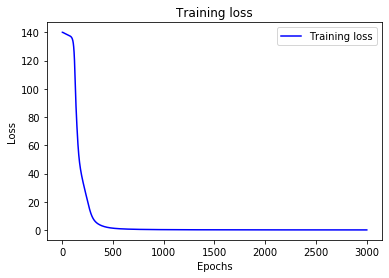

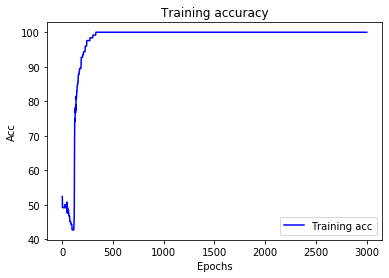

In [223]:
nn.plot_performance(history)

In [224]:
print('Test acc:', nn.evaluate(X_test, y_test))

Test acc: 100.0


### Keras model

In [225]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(64, activation='sigmoid', input_shape=(X_train.shape[1],)))
model.add(keras.layers.Dense(64))
model.add(keras.layers.Dense(3, activation='softmax'))
opt = keras.optimizers.SGD(learning_rate=1e-2)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=1, verbose=0)

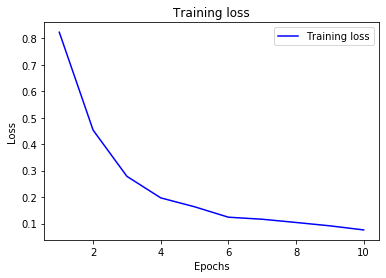

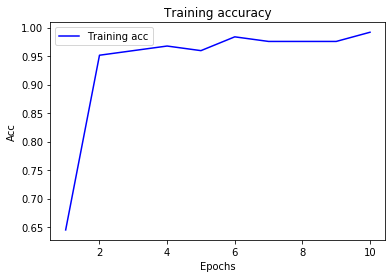

In [226]:
plot_model_performance(history)

In [227]:
model.evaluate(X_test, y_test)

54/54 [==============================] - 0s 2ms/step


[0.07097388638390435, 1.0]